In [2]:
!pip install rasterio wget tensorflow==2.4.1 tensorflow_addons[tensorflow]

     |████████████████████████████████| 394.3 MB 7.3 kB/s  eta 0:00:01     |████████████████████▌           | 252.1 MB 77.7 MB/s eta 0:00:02     |█████████████████████           | 259.7 MB 77.7 MB/s eta 0:00:02███▌        | 289.4 MB 80.7 MB/s eta 0:00:02
     |████████████████████████████████| 703 kB 68.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 78.6 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 47.1 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 45.9 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.8 MB/s  eta 0:00:01
     |████████████████████████████████| 6.0 MB 45.4 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 49.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 49.5 MB/s eta 0:00:01
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=05f2904035c2b42fe48336786aeddd3d1892f28ba93edc1357bf741e445b3199
  Stored in directory: /home/ec2-user/.cache/pip/w

In [4]:
!sudo mount -t nfs4 -o nfsvers=4.1,rsize=1048576,wsize=1048576,hard,timeo=600,retrans=2,noresvport 172.31.9.243:/ ./efs

## Imports

In [2]:
import os
import multiprocessing
import rasterio
import tensorflow as tf
from glob import glob
import pickle
import numpy as np
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow_addons.metrics import F1Score
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy

from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import boto3
import io
from test_generator import TestGenerator
np.set_printoptions(suppress=True)
np.set_printoptions(precision=6)

In [3]:
print(tf.__version__)

2.4.1


# Evaluation Code - Outdated

#### Variables definition

In [25]:
# label_list = ["Habitation", "Industrial_agriculture", "Mining", "Rainforest", "River", "Roads", "Savannah", 
#               "Shifting_cultivation", "Water"]

new_label_list = ["Industrial_agriculture","ISL","Mining","Roads","Shifting_cultivation"]

# 1:"Industrial_agriculture"
# 2:"ISL"
# 3:"Mining"
# 4:"Roads"
# 5:"Shifting_cultivation"


numclasses = len(new_label_list)
bands_all = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18]
bands_RGBNIRN = [2, 3, 4, 8, 18]
# input_shape_all_bands= (100,100,len(bands_all))
input_shape_RGBNIRN = (100,100,len(bands_RGBNIRN))


#### Define model (same architecture as the one used for the training)

In [4]:
def define_model(numclasses,input_shape,starting_checkpoint=None,lcl_chkpt_dir=None):
        # parameters for CNN
        input_tensor = Input(shape=input_shape)

        # introduce a additional layer to get from bands to 3 input channels
        input_tensor = Conv2D(3, (1, 1))(input_tensor)

        base_model_resnet50 = keras.applications.ResNet50(include_top=False,
                                  weights='imagenet',
                                  input_shape=(100, 100, 3))
        base_model = keras.applications.ResNet50(include_top=False,
                         weights=None,
                         input_tensor=input_tensor)

        for i, layer in enumerate(base_model_resnet50.layers):
            # we must skip input layer, which has no weights
            if i == 0:
                continue
            base_model.layers[i+1].set_weights(layer.get_weights())

        # add a global spatial average pooling layer
        top_model = base_model.output
        top_model = GlobalAveragePooling2D()(top_model)

        # let's add a fully-connected layer
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        # and a logistic layer
        predictions = Dense(numclasses, activation='sigmoid')(top_model)

        # this is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)
    #     model = model.layers[-1].bias.assign([0.0]) # WIP getting an error ValueError: Cannot assign to variable dense_8/bias:0 due to variable shape (10,) and value shape (1,) are incompatible

#         model.summary()
        if starting_checkpoint:
            s3 = boto3.resource('s3')
            chkpt_name = lcl_chkpt_dir + '/' + 'start_chkpt.h5'
            s3.download_file('canopy-production-ml-output', starting_checkpoint, chkpt_name)
            model.load_weights(chkpt_name)
    
        return model

In [5]:
# model_all_bands = define_model(numclasses, input_shape_all_bands)

# # Set the metrics we want to use for the evaluation
# model_all_bands.compile(loss=SigmoidFocalCrossEntropy(), # https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy
#                   optimizer=keras.optimizers.Adam(0.001),
#                   metrics=[tf.metrics.BinaryAccuracy(name='accuracy'), 
#                            tf.keras.metrics.Precision(name='precision'), # Computes the precision of the predictions with respect to the labels.
#                            tf.keras.metrics.Recall(name='recall'), # Computes the recall of the predictions with respect to the labels.
#                            F1Score(num_classes=numclasses, name="f1_score") # https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
#                            ]
#                  )

model_RGBNIRN = define_model(numclasses, input_shape_RGBNIRN)

# Set the metrics we want to use for the evaluation
model_RGBNIRN.compile(loss=SigmoidFocalCrossEntropy(), # https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy
                  optimizer=keras.optimizers.Adam(0.001),
                  metrics=[tf.metrics.BinaryAccuracy(name='accuracy'), 
                           tf.keras.metrics.Precision(name='precision'), # Computes the precision of the predictions with respect to the labels.
                           tf.keras.metrics.Recall(name='recall'), # Computes the recall of the predictions with respect to the labels.
                           F1Score(num_classes=numclasses, name="f1_score") # https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
                           ]
                 )

#### Get the pre-trained weights from s3 (download them locally and then use the path in load_weights)

In [39]:
# KEY = "ckpt/pc-tf-custom-container-test-job-all-ban-2021-03-15-22-50-21-572/model_resnet_epoch_4.h5"

# s3 = boto3.resource('s3')
# s3.Bucket('canopy-production-ml-output').download_file(KEY, 'model_weights_all_bands.h5')

s3_uri = "s3://canopy-production-ml-output/ckpt/pc-tf-custom-container-test-job-RGBNIRN-2021-04-05-21-57-36-707/model_resnet_epoch_28.h5"

KEY = "/".join(s3_uri.split("/")[3:])
# KEY = "ckpt/pc-tf-custom-container-test-job-RGBNIRN-2021-03-27-02-29-15-006/model_resnet_epoch_31.h5"
s3 = boto3.resource('s3')
s3.Bucket('canopy-production-ml-output').download_file(KEY, 'model_weights_RGBNIRN.h5')

In [40]:
# model_all_bands.load_weights("model_weights_all_bands.h5")
model_RGBNIRN.load_weights("model_weights_RGBNIRN.h5")

ValueError: You are trying to load a weight file containing 5 layers into a model with 110 layers.

#### Test Set generator

In [35]:
batch_size = 64
# csv_path = "labels_test.csv" 
# new_csv_path = "new_test_labels_v2.csv" 
# new_csv_path_one_third = "new_test_labels_v3_one_third.csv"
train_set = "new_train_labels_v7_one_quarter.csv"
new_csv_path_one_third = "new_test_labels_v3_one_third_uri_only.csv"
val_labels = "new_val_labels_v3.csv"

# gen_all_bands = TestGenerator(label_file_path_test=csv_path, 
#                          bucket_name='canopy-production-ml',
#                          label_mapping_path="labels.json",
#                          data_extension_type='.tif',
#                          bands=bands_all,
#                          test_data_shape=input_shape_all_bands,
#                          test_data_batch_size=batch_size,
#                          enable_data_prefetch=False,
#                          data_prefetch_size=tf.data.experimental.AUTOTUNE,
#                          num_parallel_calls=2 * multiprocessing.cpu_count(),
#                          output_shape=(tf.float32, tf.float32))

gen_RGBNIRN = TestGenerator(label_file_path_test=val_labels,
                            training_dir = "./efs",
                         bucket_name='canopy-production-ml',
                         label_mapping_path="new_labels.json",
                         data_extension_type='.tif',
                            file_mode="file",
                         bands=bands_RGBNIRN,
                         test_data_shape=input_shape_RGBNIRN,
                         test_data_batch_size=batch_size,
                         enable_data_prefetch=False,
                         data_prefetch_size=tf.data.experimental.AUTOTUNE,
                         num_parallel_calls=2 * multiprocessing.cpu_count(),
                         output_shape=(tf.float32, tf.float32))

The file new_val_labels_v3.csv is missing positive labels for classes []
test on 19902 images


In [36]:
# for img, label in gen_all_bands.test_dataset:
#     print(img.shape)
#     break

#### Run Evaluation on the test set 

In [37]:
# loss_all_bands, accuracy_all_bands, precision_all_bands, recall_all_bands, f1score_all_bands = model_all_bands.evaluate(gen_all_bands.test_dataset) 

In [38]:
loss_RGBNIRN, accuracy_RGBNIRN, precision_RGBNIRN, recall_RGBNIRN, f1score_RGBNIRN = model_RGBNIRN.evaluate(gen_RGBNIRN.test_dataset) 

311/311 [==============================] - 609s 2s/step - loss: 3.9856 - accuracy: 0.9125 - precision: 0.0333 - recall: 0.1238 - f1_score: 0.0138


#### Predict on one image

In [12]:
s3 = boto3.resource('s3')
# TODO test on entire test dataset
BUCKET_NAME = 'canopy-production-ml'
obj = s3.Object(BUCKET_NAME, "chips/cloudfree-merge-polygons/split/test/100/100_1000_1000.tif")
obj_bytes = io.BytesIO(obj.get()['Body'].read())
with rasterio.open(obj_bytes) as src:
    img_test = np.transpose(src.read(bands_RGBNIRN), (1, 2, 0))
print(img_test.shape)


(100, 100, 5)


In [13]:
predictions = model_RGBNIRN.predict(np.array([img_test]))

threshold = .2  
argsort_list = list(np.argsort(np.array(predictions[0])))
argsort_list.reverse()
pred_labels = []
for top_matches in argsort_list:
    if predictions[0][top_matches] > threshold:
        pred_labels.append(new_label_list[top_matches])

print("This chip was predicted to belong to these classes:")
print(pred_labels)


This chip was predicted to belong to these classes:
['Shifting_cultivation']


In [72]:
# print("correct label")

# def get_label(chip_uri,csv_path=csv_path):
    
#     df1 = pd.read_csv(csv_path)
#     df2 = pd.read_csv("/cb_feature_detection/data-prep/local_multi_label.csv")
    
#     return df2[df2["labels"].contains(chip_uri)]
    
# get_label("100/100_1000_1000.tif")





#### Prediction on the test set

In [11]:
# Predict on all chips in test set
# y_pred_all_bands = model_all_bands.predict(gen_all_bands.test_dataset, verbose=1)
y_pred_RGBNIRN = model_RGBNIRN.predict(gen_RGBNIRN.test_dataset, verbose=1)

1119/1119 [==============================] - 2258s 2s/step


In [74]:
# print(y_pred_all_bands[0])
print(y_pred_RGBNIRN[0])

[0. 0. 0. 0. 0.]


In [15]:
csv_path = "new_test_labels_v2.csv"

# Get true labels from csv file 
y_true_2 = pd.read_csv(new_csv_path_one_third).drop('paths', 1)
y_true = np.array([y_true_2.loc[i].to_list() for i in range(len(y_true_2))])
print(y_true)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 ...
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [92]:
def compare_ytrue_ypred(y_true, y_pred,threshold=0.2):
    for idx in range(len(y_pred)):
        argsort_list = list(np.argsort(np.array(y_pred[idx])))
        argsort_list.reverse()
        true_classes_list = [ i for i in range(len(y_true[idx])) if y_true[idx][i] == 1 ]
        print(f"\n{idx}) True labels:")
        print([label_list[index] for index in true_classes_list])
        pred_labels = []
        for top_matches in argsort_list:
            if y_pred[idx][top_matches] > threshold:
                pred_labels.append(label_list[top_matches])
        print("Predicted labels:")
        print(pred_labels)
#         break
# compare_ytrue_ypred(y_true, y_pred,threshold=0.2)

#### Confusion matrices

In [93]:
y_pred_RGBNIRN

array([[0.463414, 0.671276, 0.411386, 0.504151, 0.458109],
       [0.47129 , 0.660981, 0.411713, 0.514719, 0.44633 ],
       [0.471118, 0.661492, 0.411457, 0.514485, 0.446558],
       ...,
       [0.472249, 0.666953, 0.410783, 0.511884, 0.448089],
       [0.472249, 0.666953, 0.410783, 0.511884, 0.448089],
       [0.472249, 0.666953, 0.410783, 0.511884, 0.448089]], dtype=float32)

In [16]:
threshold = .2

# y_pred_all_bands_threshold = np.where(y_pred_all_bands > threshold, 1, 0)
y_pred_RGBNIRN_threshold = np.where(y_pred_RGBNIRN > threshold, 1, 0)
y_pred_RGBNIRN_threshold

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [17]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
# matrices_all_bands = multilabel_confusion_matrix(y_true, y_pred_all_bands_threshold)
matrices_RGBNIRN = multilabel_confusion_matrix(y_true, y_pred_RGBNIRN_threshold)

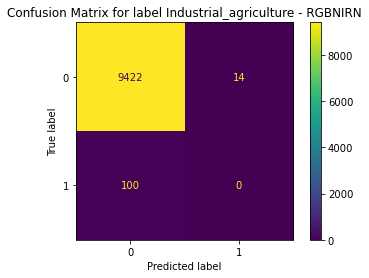

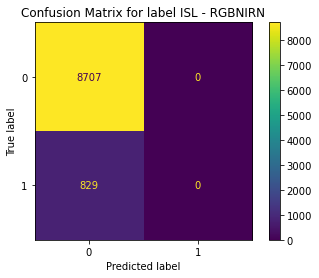

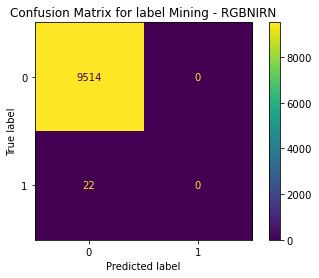

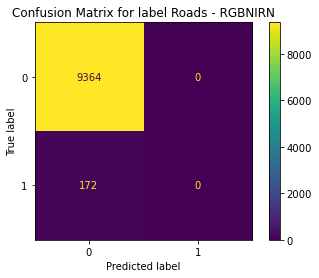

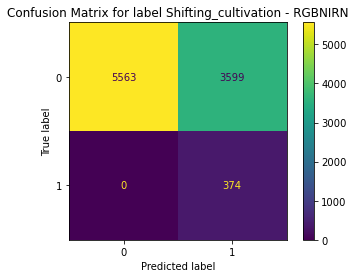

In [18]:
# if no label x on chip i then label = 0 and predicted should = 0 otherwise if label predicted = 1 then it is wrongly classifiying the label (FP)
# if label x on chip i then label = 1 and predicted should = 1 otherwise if label predicted = 0 then it is missing the label classification (FN)
for i in range(len(new_label_list)):
#     cmd = ConfusionMatrixDisplay(matrices_all_bands[i], display_labels=np.unique(y_true)).plot()
#     plt.title(f'Confusion Matrix for label {label_list[i]} - All bands')
#     plt.show()    
    cmd = ConfusionMatrixDisplay(matrices_RGBNIRN[i], display_labels=np.unique(y_true)).plot()
    plt.title(f'Confusion Matrix for label {new_label_list[i]} - RGBNIRN')
    plt.show()

In [31]:
KEY = "s3://canopy-production-ml-output/ckpt/pc-tf-custom-container-test-job-RGBNIRN-2021-04-05-19-32-30-906/model_resnet_epoch_3.h5"
s3 = boto3.resource('s3')
s3.Bucket('canopy-production-ml-output').download_file(KEY, 'model_weights_all_bands.h5')

In [32]:
model_all_bands.load_weights("model_weights_all_bands.h5")

In [34]:
y_pred_all_bands_2 = model_all_bands.predict(gen_all_bands.test_dataset, verbose=1)

7706/7706 [==============================] - 2592s 336ms/step


In [35]:
y_pred_all_bands_threshold_2 = np.where(y_pred_all_bands_2 > threshold, 1, 0)
y_pred_all_bands_threshold_2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

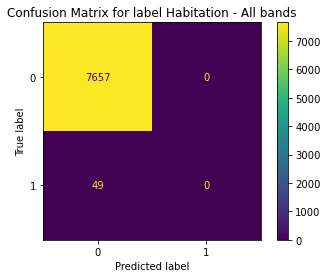

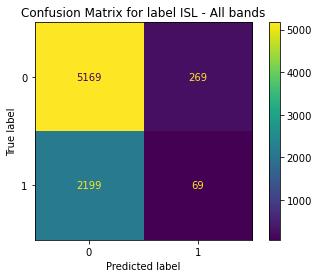

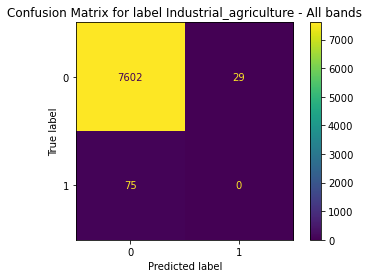

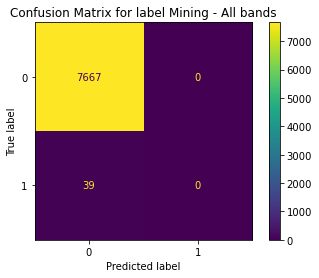

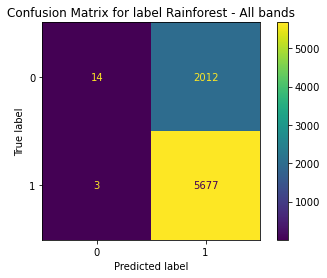

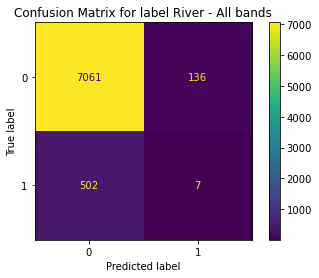

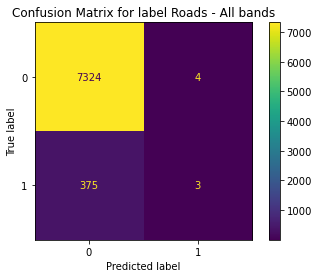

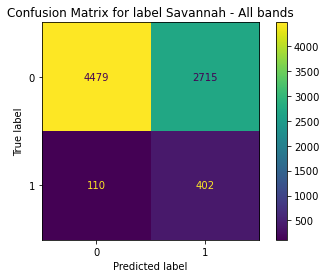

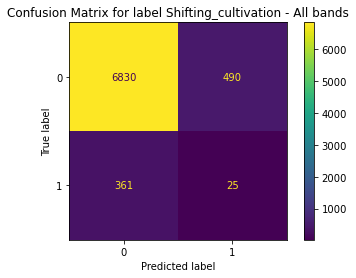

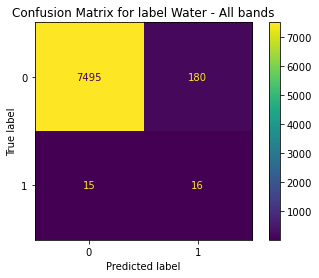

In [36]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
matrices_all_bands_2 = multilabel_confusion_matrix(y_true, y_pred_all_bands_threshold_2)
for i in range(len(label_list)):
    cmd = ConfusionMatrixDisplay(matrices_all_bands_2[i], display_labels=np.unique(y_true)).plot()
    plt.title(f'Confusion Matrix for label {label_list[i]} - All bands')
    plt.show()    

In [ ]:
loss_all_bands, accuracy_all_bands, precision_all_bands, recall_all_bands, f1score_all_bands = model_all_bands.evaluate(gen_all_bands.test_dataset) 

# Updated Eval Code - To be used ad hoc for new subsequent checkpoints

In [ ]:
# label_list = ["Habitation", "Industrial_agriculture", "Mining", "Rainforest", "River", "Roads", "Savannah", 
#               "Shifting_cultivation", "Water"]

new_label_list = ["Industrial_agriculture","ISL","Mining","Roads","Shifting_cultivation"]

# 1:"Industrial_agriculture"
# 2:"ISL"
# 3:"Mining"
# 4:"Roads"
# 5:"Shifting_cultivation"


numclasses = len(new_label_list)
bands_all = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18]
bands_RGBNIRN_old = [2, 3, 4, 8,18]
bands_RGBNIRN = [2, 3, 4, 8,12]
bands_RGBNIRSWR1SWR2 = [2, 3, 4, 8,11,12]
bands_RGBNIRSWR1SWR2NDVI = [2, 3, 4, 8,11,12,18]
# input_shape_all_bands= (100,100,len(bands_all))
input_shape_RGBNIRN = (100,100,len(bands_RGBNIRN))
input_shape_RGBNIRN_old = (100,100,len(bands_RGBNIRN_old))
input_shape_RGBNIRSWR1SWR2 = (100,100,len(bands_RGBNIRSWR1SWR2))
input_shape_RGBNIRSWR1SWR2NDVI = (100,100,len(bands_RGBNIRSWR1SWR2NDVI))
input_shape_all = (100,100,len(bands_all))

margaux_LR = 0.001


In [ ]:
# def Simple_CNN(numclasses, input_shape): #TODO use a more complex CNN
#     model = Sequential([
#         layers.Input(input_shape),
#         layers.Conv2D(16, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(32, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(64, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Flatten(),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(numclasses, activation="softmax")
#     ])
#     return model

def define_model(numclasses,input_shape,starting_checkpoint=None,lcl_chkpt_dir=None):
        # parameters for CNN
        input_tensor = Input(shape=input_shape)

        # introduce a additional layer to get from bands to 3 input channels
        input_tensor = Conv2D(3, (1, 1))(input_tensor)

        base_model_resnet50 = keras.applications.ResNet50(include_top=False,
                                  weights='imagenet',
                                  input_shape=(100, 100, 3))
        base_model = keras.applications.ResNet50(include_top=False,
                         weights=None,
                         input_tensor=input_tensor)

        for i, layer in enumerate(base_model_resnet50.layers):
            # we must skip input layer, which has no weights
            if i == 0:
                continue
            base_model.layers[i+1].set_weights(layer.get_weights())

        # add a global spatial average pooling layer
        top_model = base_model.output
        top_model = GlobalAveragePooling2D()(top_model)

        # let's add a fully-connected layer
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        # and a logistic layer
        predictions = Dense(numclasses, activation='sigmoid')(top_model)

        # this is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)
    #     model = model.layers[-1].bias.assign([0.0]) # WIP getting an error ValueError: Cannot assign to variable dense_8/bias:0 due to variable shape (10,) and value shape (1,) are incompatible

#         model.summary()
        if starting_checkpoint:
            s3 = boto3.resource('s3')
            chkpt_name = lcl_chkpt_dir + '/' + 'start_chkpt.h5'
            s3.download_file('canopy-production-ml-output', starting_checkpoint, chkpt_name)
            model.load_weights(chkpt_name)
    
        return model
    


In [ ]:
model_RGBNIRN = define_model(numclasses, input_shape_RGBNIRSWR1SWR2NDVI)

In [ ]:
# Set the metrics we want to use for the evaluation
model_RGBNIRN.compile(loss=BinaryCrossentropy(), # https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy
                  optimizer=keras.optimizers.Adam(margaux_LR),
                   metrics=[tf.metrics.BinaryAccuracy(name='accuracy'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Precision(class_id=1,name='ISL_precision'),
                           # Computes the precision of the predictions with respect to the labels.
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Recall(class_id=1,name='ISL_recall'),
                           # Computes the recall of the predictions with respect to the labels.
                           F1Score(num_classes=numclasses, name="f1_score")
                           # https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
                           ]
                  )




In [ ]:
s3_uri = "s3://canopy-production-ml-output/ckpt/pc-tf-custom-container-2021-04-20-05-16-47-844/model_weights_very_best.h5"

KEY = "/".join(s3_uri.split("/")[3:])
s3 = boto3.resource('s3')
s3.Bucket('canopy-production-ml-output').download_file(KEY, 'model_weights_RGBNIRN.h5')

In [ ]:
# model_all_bands.load_weights("model_weights_all_bands.h5")
model_RGBNIRN.load_weights("model_weights_RGBNIRN.h5")

In [ ]:
batch_size = 64
# csv_path = "labels_test.csv" 
# new_csv_path = "new_test_labels_v2.csv" 
# new_csv_path_one_third = "new_test_labels_v3_one_third.csv"
train_set = "new_train_labels_v7_one_quarter.csv"
test_set = "new_test_labels_v3_one_third_uri_only.csv"
val_labels = "new_val_labels_v3.csv"

# gen_all_bands = TestGenerator(label_file_path_test=test_set,
#                               training_dir = "./efs/",
#                          bucket_name='canopy-production-ml',
#                          label_mapping_path="new_labels.json",
#                          data_extension_type='.tif',
#                               file_mode="file",
#                          bands=bands_all,
#                          test_data_shape=input_shape_all,
#                          test_data_batch_size=batch_size,
#                          enable_data_prefetch=False,
#                          data_prefetch_size=tf.data.experimental.AUTOTUNE,
#                          num_parallel_calls=2 * multiprocessing.cpu_count(),
#                          output_shape=(tf.float32, tf.float32))

gen_RGBNIRN = TestGenerator(label_file_path_test=test_set,
                            training_dir = "./efs",
                         bucket_name='canopy-production-ml',
                         label_mapping_path="new_labels.json",
                         data_extension_type='.tif',
                            file_mode="file",
                         bands=bands_RGBNIRSWR1SWR2NDVI,
                         test_data_shape=input_shape_RGBNIRSWR1SWR2NDVI,
                         test_data_batch_size=batch_size,
                         enable_data_prefetch=False,
                         data_prefetch_size=tf.data.experimental.AUTOTUNE,
                         num_parallel_calls=2 * multiprocessing.cpu_count(),
                         output_shape=(tf.float32, tf.float32))

The file new_test_labels_v3_one_third_uri_only.csv is missing positive labels for classes []
test on 9536 images


In [ ]:
model_RGBNIRN.evaluate(gen_RGBNIRN.test_dataset) 

# model_RGBNIRN.evaluate(gen_all_bands.test_dataset) 



<<<<<<< local <modified: >


149/149 [==============================] - 325s 2s/step - loss: 0.4015 - accuracy: 0.9693 - precision: 0.5118 - ISL_precision: 0.7166 - recall: 0.5050 - ISL_recall: 0.7045 - f1_score: 0.1527


149/149 [==============================] - 381s 3s/step - loss: 0.2021 - accuracy: 0.9754 - precision: 0.6223 - ISL_precision: 0.7658 - recall: 0.5471 - ISL_recall: 0.7455 - f1_score: 0.2064


>>>>>>> remote <modified: >
<<<<<<< local


[0.4015404284000397,
 0.969337522983551,
 0.5118483304977417,
 0.716564416885376,
 0.5050100088119507,
 0.7044631838798523,
 array([0.006245, 0.584445, 0.018692, 0.084433, 0.069617], dtype=float32)]

[0.20210088789463043,
 0.9753568768501282,
 0.6223404407501221,
 0.7657992839813232,
 0.5470941662788391,
 0.745476484298706,
 array([0.188791, 0.468821, 0.113208, 0.192837, 0.068487], dtype=float32)]

>>>>>>> remote


In [139]:
y_pred_RGBNIRN = model_RGBNIRN.predict(gen_RGBNIRN.test_dataset, verbose=1)

75/75 [==============================] - 285s 4s/step


In [140]:
# Get true labels from csv file 
y_true_2 = pd.read_csv(new_csv_path_one_third).drop('paths', 1)
y_true = np.array([y_true_2.loc[i].to_list() for i in range(len(y_true_2))])
print(y_true)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 ...
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [141]:
threshold = .2

# y_pred_all_bands_threshold = np.where(y_pred_all_bands > threshold, 1, 0)
y_pred_RGBNIRN_threshold = np.where(y_pred_RGBNIRN > threshold, 1, 0)
y_pred_RGBNIRN_threshold

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [142]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
matrices_RGBNIRN = multilabel_confusion_matrix(y_true, y_pred_RGBNIRN_threshold)

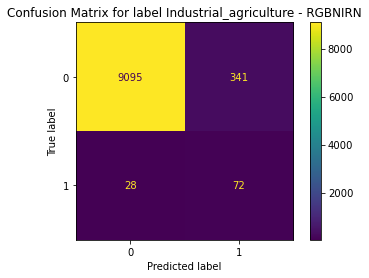

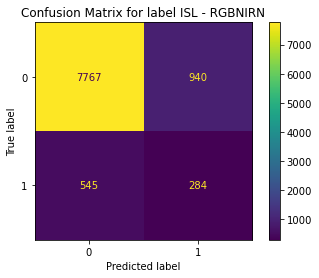

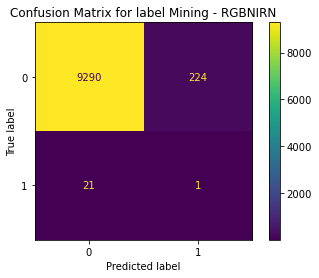

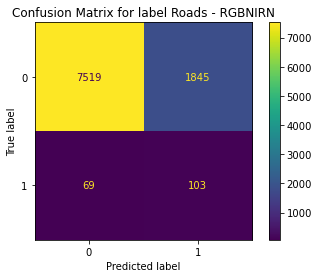

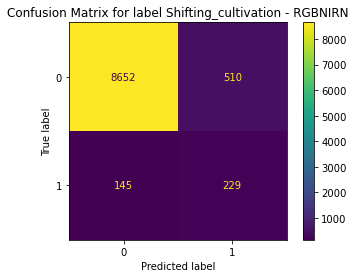

In [143]:
for i in range(len(new_label_list)):
    cmd = ConfusionMatrixDisplay(matrices_RGBNIRN[i], display_labels=np.unique(y_true)).plot()
    plt.title(f'Confusion Matrix for label {new_label_list[i]} - RGBNIRN')
    plt.show()

# Eval Pipeline - To be used once checkpoint finalized

In [6]:
new_label_list = ["Industrial_agriculture","ISL","Mining","Roads","Shifting_cultivation"]

# 1:"Industrial_agriculture"
# 2:"ISL"
# 3:"Mining"
# 4:"Roads"
# 5:"Shifting_cultivation"


numclasses = len(new_label_list)
bands_RGBNIRSWR1SWR2NDVI = [2, 3, 4, 8,11,12,18]
input_shape_RGBNIRSWR1SWR2NDVI = (100,100,len(bands_RGBNIRSWR1SWR2NDVI))

margaux_LR = 0.001

In [39]:
s3 = boto3.resource('s3')
model_url = "s3://canopy-production-ml/inference/model_files/model-best.h5"
checkpoint_url = "s3://canopy-production-ml/inference/model_files/model_weights_best.h5"
model_filename = "model.h5"
model_weights_filename = "model_weights.h5"


In [42]:
#Download Weights

bucket = checkpoint_url.split("/")[2]
model_key = "/".join(model_url.split("/")[3:])
s3.Bucket(bucket).download_file(model_key, model_filename)
weights_key = "/".join(checkpoint_url.split("/")[3:])
s3.Bucket(bucket).download_file(weights_key, model_weights_filename)

In [43]:
model_test = tf.keras.models.load_model(model_filename)
model_test.load_weights(model_weights_filename)

In [49]:
batch_size = 64
# csv_path = "labels_test.csv" 
# new_csv_path = "new_test_labels_v2.csv" 
# new_csv_path_one_third = "new_test_labels_v3_one_third.csv"
train_set = "new_train_labels_v7_one_quarter.csv"
test_set = "new_test_labels_v3_one_third_uri_only.csv"
val_labels = "new_val_labels_v3.csv"

# gen_all_bands = TestGenerator(label_file_path_test=test_set,
#                               training_dir = "./efs/",
#                          bucket_name='canopy-production-ml',
#                          label_mapping_path="new_labels.json",
#                          data_extension_type='.tif',
#                               file_mode="file",
#                          bands=bands_all,
#                          test_data_shape=input_shape_all,
#                          test_data_batch_size=batch_size,
#                          enable_data_prefetch=False,
#                          data_prefetch_size=tf.data.experimental.AUTOTUNE,
#                          num_parallel_calls=2 * multiprocessing.cpu_count(),
#                          output_shape=(tf.float32, tf.float32))

gen_RGBNIRN = TestGenerator(label_file_path_test=test_set,
                            training_dir = "./efs",
                         bucket_name='canopy-production-ml',
                         label_mapping_path="new_labels.json",
                         data_extension_type='.tif',
                            file_mode="file",
                         bands=bands_RGBNIRSWR1SWR2NDVI,
                         test_data_shape=input_shape_RGBNIRSWR1SWR2NDVI,
                         test_data_batch_size=batch_size,
                         enable_data_prefetch=False,
                         data_prefetch_size=tf.data.experimental.AUTOTUNE,
                         num_parallel_calls=2 * multiprocessing.cpu_count(),
                         output_shape=(tf.float32, tf.float32))

The file new_test_labels_v3_one_third_uri_only.csv is missing positive labels for classes []
test on 9536 images


In [50]:
model_test.evaluate(gen_RGBNIRN.test_dataset)

149/149 [==============================] - 334s 2s/step - loss: 0.2981 - accuracy: 0.9753 - precision: 0.6103 - ISL_precision: 0.7656 - recall: 0.5858 - ISL_recall: 0.7841 - f1_score: 0.1996


[0.29807162284851074,
 0.9752516746520996,
 0.6102992296218872,
 0.7656065821647644,
 0.5858383178710938,
 0.7840772271156311,
 array([0.144928, 0.652112, 0.032345, 0.103586, 0.065174], dtype=float32)]

In [7]:
s3 = boto3.resource('s3')
# TODO test on entire test dataset
BUCKET_NAME = 'canopy-production-ml'
obj = s3.Object(BUCKET_NAME, "chips/cloudfree-merge-polygons/split/test/100/100_1000_1000.tif")
obj_bytes = io.BytesIO(obj.get()['Body'].read())
with rasterio.open(obj_bytes) as src:
    img_test = np.transpose(src.read(bands_RGBNIRSWR1SWR2NDVI), (1, 2, 0))
print(img_test.shape)

(100, 100, 7)


In [9]:
type(img_test)

numpy.ndarray

In [58]:
model_test.predict(np.array([img_test]))

array([[0., 0., 0., 0., 1.]], dtype=float32)

# Sandbox

In [58]:
df

,0,1,2,3,4,paths
0,0,0,0,0,0,12_2800_2200.tif
1,0,0,0,0,0,12_1800_0.tif
2,0,0,0,0,0,12_3200_3800.tif
3,0,0,0,0,0,12_4500_4100.tif
4,0,0,0,0,0,12_900_4200.tif
...,...,...,...,...,...,...
19897,0,0,0,0,0,101_2800_1300.tif
19898,0,0,0,0,1,101_1700_2800.tif
19899,0,0,0,0,0,101_2500_3300.tif
19900,0,0,0,0,1,101_1900_1600.tif


In [26]:
df["0"]

0       0
1       0
2       0
3       0
4       0
       ..
9531    0
9532    0
9533    0
9534    0
9535    0
Name: 0, Length: 9536, dtype: int64